/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔥 [Start] Flux.1-dev 광고 생성 (8-bit Error Fix Version)

🚀 [Phase 1] 누끼 작업 (BiRefNet)...
🧹 [Memory] VRAM Cleaned.


/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


🧹 [Memory] VRAM Cleaned.

🚀 [Phase 2] 배경 생성 (Flux 8-bit Component Mode)...
🧹 [Memory] VRAM Cleaned.
   ...Loading 8-bit Transformer


Loading checkpoint shards: 100%|██████████| 3/3 [01:40<00:00, 33.35s/it]


   ...Loading Pipeline


Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.
  0%|          | 0/28 [00:00<?, ?it/s]/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
100%|██████████| 28/28 [01:10<00:00,  2.51s/it]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


🧹 [Memory] VRAM Cleaned.

🚀 [Phase 3] 레이아웃 및 텍스트 가이드...

🚀 [Phase 4] Flux 통합 리터칭 (Flux 8-bit)...
🧹 [Memory] VRAM Cleaned.
   ...Loading 8-bit Transformer


Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.
Token indices sequence length is longer than the specified maximum sequence length for this model (116 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["린이집 간식 시간'is written in golden embossed letters below. warm sunlight, cinematic lighting, high quality, 8 k, extremely detailed texture."]
100%|██████████| 20/20 [00:50<00:00,  2.51s/it]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


🧹 [Memory] VRAM Cleaned.


/tmp/ipykernel_1969/2122131834.py:57: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1969/2122131834.py:57: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1969/2122131834.py:57: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1969/2122131834.py:57: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1969/2122131834.py:57: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1969/2122131834.py:57: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1969/2122131834.py:57: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from font(s) DejaVu Sans.
  plt.tight_la

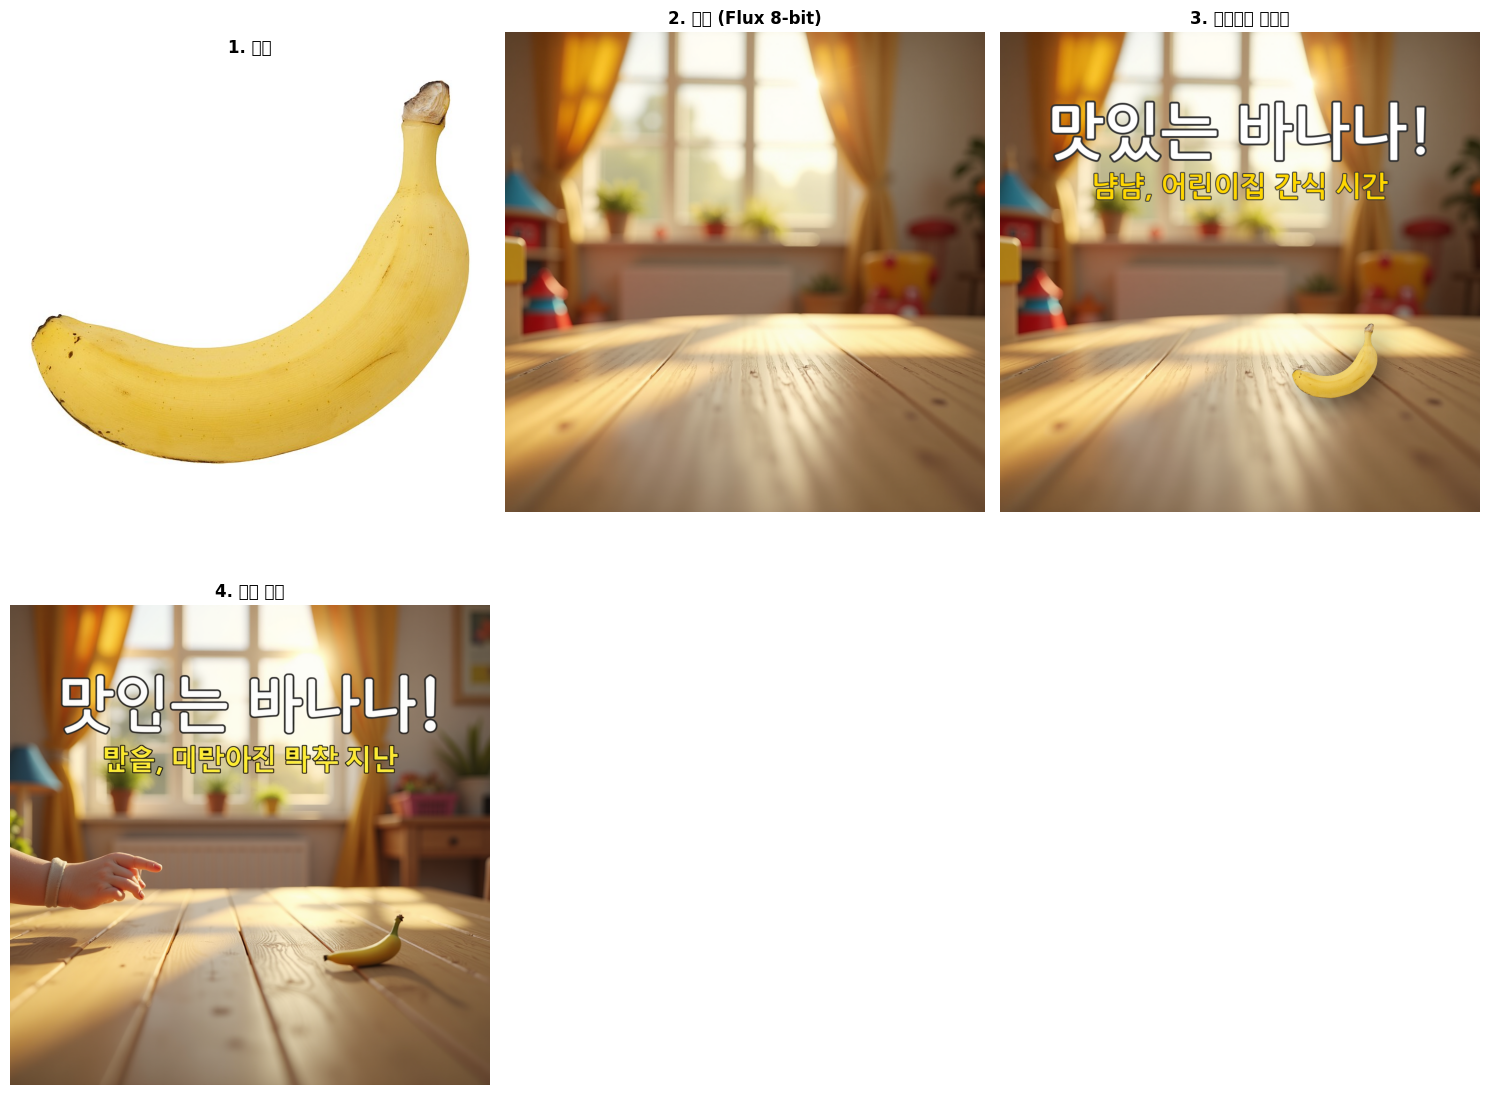

In [1]:
import torch
import gc
import os
import requests
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter
from torchvision import transforms
from transformers import AutoModelForImageSegmentation, BitsAndBytesConfig
# ⚠️ 수정됨: FluxTransformer2DModel 추가 (개별 로딩용)
from diffusers import FluxPipeline, FluxImg2ImgPipeline, FluxTransformer2DModel
from diffusers.utils import load_image
from huggingface_hub import login
import matplotlib.pyplot as plt
import math

# ==========================================
# 🔑 [필수] 허깅페이스 토큰 입력
# ==========================================
# 실행 전 본인의 토큰을 아래 "hf_..." 부분에 넣어주세요.
HF_TOKEN = "hf_..." 
# login(token=HF_TOKEN) # 토큰 입력 후 주석(#) 제거하고 실행하세요

# ==========================================
# ⚙️ 설정
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.bfloat16 

MODEL_IDS = {
    "SEG": "ZhengPeng7/BiRefNet",
    "FLUX": "black-forest-labs/FLUX.1-dev"
}

def flush():
    gc.collect()
    torch.cuda.empty_cache()
    print("🧹 [Memory] VRAM Cleaned.")

def download_font(font_name="NanumGothicBold.ttf"):
    if not os.path.exists(font_name):
        url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Bold.ttf"
        r = requests.get(url)
        with open(font_name, 'wb') as f:
            f.write(r.content)
    return font_name

def plot_steps(step_images):
    n = len(step_images)
    cols = 3
    rows = math.ceil(n / cols)
    plt.figure(figsize=(15, 6 * rows))
    for i, (img, title) in enumerate(step_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(title, fontsize=12, fontweight='bold')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# [Phase 1] 누끼 (기존 동일)
def run_segmentation(image_path):
    print("\n🚀 [Phase 1] 누끼 작업 (BiRefNet)...")
    flush()
    model = AutoModelForImageSegmentation.from_pretrained(MODEL_IDS["SEG"], trust_remote_code=True)
    model.to(DEVICE)
    model.eval()
    img = load_image(image_path).convert("RGB")
    W, H = img.size
    img_input = img.resize((1024, 1024), Image.LANCZOS)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(img_input).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        preds = model(input_tensor)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()
    mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
    mask = mask.point(lambda x: 255 if x > 120 else 0)
    fg = img.copy()
    fg.putalpha(mask)
    del model, input_tensor
    flush()
    return img, fg, mask

# ==========================================
# 🛠️ [Phase 2] 배경 생성 (8-bit Component Loading)
# ==========================================
def run_flux_bg():
    print("\n🚀 [Phase 2] 배경 생성 (Flux 8-bit Component Mode)...")
    flush()
    
    # 🔥 [핵심 수정] 트랜스포머만 따로 8-bit로 로드 (에러 방지)
    quant_config = BitsAndBytesConfig(
        load_in_8bit=True
    )
    
    print("   ...Loading 8-bit Transformer")
    transformer = FluxTransformer2DModel.from_pretrained(
        MODEL_IDS["FLUX"],
        subfolder="transformer",
        quantization_config=quant_config,
        torch_dtype=TORCH_DTYPE
    )
    
    print("   ...Loading Pipeline")
    pipe = FluxPipeline.from_pretrained(
        MODEL_IDS["FLUX"],
        transformer=transformer, # 8-bit 트랜스포머 주입
        torch_dtype=TORCH_DTYPE
    )
    
    # 8-bit 모델은 가벼우므로 빠른 Offload 사용 가능
    pipe.enable_model_cpu_offload()
    
    prompt = (
        "A macro shot of a small, cute wooden table surface in a cozy daycare center. "
        "Blurred background with colorful toys and warm sunlight streaming through a window. "
        "Soft bokeh, photorealistic, 8k resolution, cinematic lighting, warm tone."
    )
    
    image = pipe(
        prompt,
        height=1024,
        width=1024,
        guidance_scale=3.5,
        num_inference_steps=28,
        max_sequence_length=512,
        generator=torch.Generator("cpu").manual_seed(42)
    ).images[0]
    
    del pipe, transformer
    flush()
    return image

# [Phase 3] 파이썬 합성 (기존 동일)
def run_manual_composition(bg, fg, mask):
    print("\n🚀 [Phase 3] 레이아웃 및 텍스트 가이드...")
    bg_w, bg_h = bg.size
    fg_w, fg_h = fg.size
    scale = 0.25 
    new_w, new_h = int(fg_w * scale), int(fg_h * scale)
    fg_resized = fg.resize((new_w, new_h), Image.LANCZOS)
    mask_resized = mask.resize((new_w, new_h), Image.LANCZOS)
    obj_x = int(bg_w * 0.6)
    obj_y = int(bg_h * 0.6)
    shadow = Image.new("RGBA", bg.size, (0,0,0,0))
    shadow.paste((0,0,0,150), (obj_x+10, obj_y+15), mask=mask_resized)
    shadow = shadow.filter(ImageFilter.GaussianBlur(25))
    comp = bg.convert("RGBA")
    comp = Image.alpha_composite(comp, shadow)
    fg_layer = Image.new("RGBA", bg.size, (0,0,0,0))
    fg_layer.paste(fg_resized, (obj_x, obj_y), mask=fg_resized)
    comp = Image.alpha_composite(comp, fg_layer)
    draw = ImageDraw.Draw(comp)
    font_path = download_font()
    main_text = "맛있는 바나나!"
    sub_text = "냠냠, 어린이집 간식 시간"
    font_main = ImageFont.truetype(font_path, 130)
    font_sub = ImageFont.truetype(font_path, 60)
    def get_pos(text, font, y_offset):
        bbox = draw.textbbox((0,0), text, font=font)
        w = bbox[2] - bbox[0]
        return ((bg_w - w) // 2, y_offset)
    draw.text(get_pos(main_text, font_main, 150), main_text, font=font_main, fill="white", stroke_width=4, stroke_fill="#333")
    draw.text(get_pos(sub_text, font_sub, 300), sub_text, font=font_sub, fill="#FFD700", stroke_width=2, stroke_fill="#333")
    return comp.convert("RGB")

# ==========================================
# 🛠️ [Phase 4] 리터칭 (8-bit Component Loading)
# ==========================================
def run_flux_refinement(composite_image):
    print("\n🚀 [Phase 4] Flux 통합 리터칭 (Flux 8-bit)...")
    flush()
    
    # 🔥 Phase 4도 동일하게 트랜스포머만 8-bit로 교체
    quant_config = BitsAndBytesConfig(
        load_in_8bit=True
    )
    
    print("   ...Loading 8-bit Transformer")
    transformer = FluxTransformer2DModel.from_pretrained(
        MODEL_IDS["FLUX"],
        subfolder="transformer",
        quantization_config=quant_config,
        torch_dtype=TORCH_DTYPE
    )
    
    pipe = FluxImg2ImgPipeline.from_pretrained(
        MODEL_IDS["FLUX"],
        transformer=transformer,
        torch_dtype=TORCH_DTYPE
    )
    
    pipe.enable_model_cpu_offload()
    
    prompt = (
        "A photorealistic close-up shot. A cute chubby 5-year-old child's hand reaching out "
        "to grab a small yellow banana on a wooden table. "
        "The text '맛있는 바나나!' is written in the air in 3D cute bubble letters, glowing white. "
        "The text '냠냠, 어린이집 간식 시간' is written in golden embossed letters below. "
        "Warm sunlight, cinematic lighting, high quality, 8k, extremely detailed texture."
    )
    
    final = pipe(
        prompt=prompt,
        image=composite_image,
        strength=0.65, 
        guidance_scale=3.5,
        num_inference_steps=30,
        generator=torch.Generator("cpu").manual_seed(42)
    ).images[0]
    
    del pipe, transformer
    flush()
    return final

def process_flux_ad(image_path):
    print("🔥 [Start] Flux.1-dev 광고 생성 (8-bit Error Fix Version)")
    step_images = []
    
    orig, fg, mask = run_segmentation(image_path)
    step_images.append((orig, "1. 원본"))
    
    bg = run_flux_bg()
    step_images.append((bg, "2. 배경 (Flux 8-bit)"))
    
    draft = run_manual_composition(bg, fg, mask)
    step_images.append((draft, "3. 레이아웃 가이드"))
    
    final = run_flux_refinement(draft)
    step_images.append((final, "4. 최종 결과"))
    
    final.save("final_flux_8bit.png")
    plot_steps(step_images)

# 실행
process_flux_ad("image.png")